In [ ]:
import utils
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.probability import FreqDist
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential, load_model
from keras.layers import Embedding, Dense, LSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [2]:
texts = []
labels = []
directory = '../datasets/imdb/train/pos/'
utils.load_data(directory, texts, labels)
directory = '../datasets/imdb/train/neg/'
utils.load_data(directory, texts, labels)

directory = '../datasets/imdb/test/pos/'
utils.load_data(directory, texts, labels)
directory = '../datasets/imdb/test/neg/'
utils.load_data(directory, texts, labels)

In [3]:
texts = [utils.lemmatize(utils.remove_stopwords(utils.remove_breaklines(text))) for text in texts]
texts = [utils.clean_text(text) for text in texts]

x_train, x_test, y_train, y_test = train_test_split(texts, labels, train_size=0.8, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=42)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

### Word embedding

In [4]:
fdist = FreqDist()
for text in x_train:
    for word in text.split():
        fdist[word.lower()] += 1

In [5]:
num_of_words = len([word for word in fdist if fdist[word] > 3])

In [6]:
tokenizer = Tokenizer(num_words=num_of_words,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=' ')

tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)

In [7]:
seq_lengths = [len(text.split()) for text in x_train]
max_length = max(seq_lengths)
x_train_seq = pad_sequences(x_train_seq, max_length)
x_val_seq = pad_sequences(x_val_seq, max_length)
setattr(utils, 'max_sentence_length', max_length)

### Model building

In [15]:
model = Sequential()

model.add(Embedding(num_of_words, 10))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [16]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=4, 
                               mode='min', 
                               verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=2, 
                              min_lr=0.001, 
                              mode='min', 
                              verbose=1)

checkpoint = ModelCheckpoint('sentiment_model.keras', 
                             monitor='val_loss', 
                             mode='min', 
                             save_best_only=True,
                             verbose=1)

callbacks = [early_stopping, reduce_lr, checkpoint]

history = model.fit(x_train_seq, y_train, epochs=10, batch_size=64, validation_data=(x_val_seq, y_val), callbacks=callbacks)

Epoch 1/10


2024-06-04 22:37:25.883786: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 223344000 exceeds 10% of free system memory.


563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7483 - loss: 0.4753

2024-06-04 22:50:50.686511: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24816000 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 0.29657, saving model to sentiment_model.keras
563/563 ━━━━━━━━━━━━━━━━━━━━ 814s 1s/step - accuracy: 0.7484 - loss: 0.4751 - val_accuracy: 0.8880 - val_loss: 0.2966 - learning_rate: 0.0010
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9364 - loss: 0.1780
Epoch 2: val_loss did not improve from 0.29657
563/563 ━━━━━━━━━━━━━━━━━━━━ 1164s 2s/step - accuracy: 0.9364 - loss: 0.1780 - val_accuracy: 0.8867 - val_loss: 0.3008 - learning_rate: 0.0010
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9593 - loss: 0.1236
Epoch 3: val_loss did not improve from 0.29657
563/563 ━━━━━━━━━━━━━━━━━━━━ 1186s 2s/step - accuracy: 0.9593 - loss: 0.1236 - val_accuracy: 0.8780 - val_loss: 0.3456 - learning_rate: 0.0010
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9724 - loss: 0.0854
Epoch 4: val_loss did not improve from 0.29657
563/563 ━━━━━━━━━━━━━━━━━━━━ 921s 2s/step - accuracy: 0.9724 - loss: 0.0854 - val_accurac

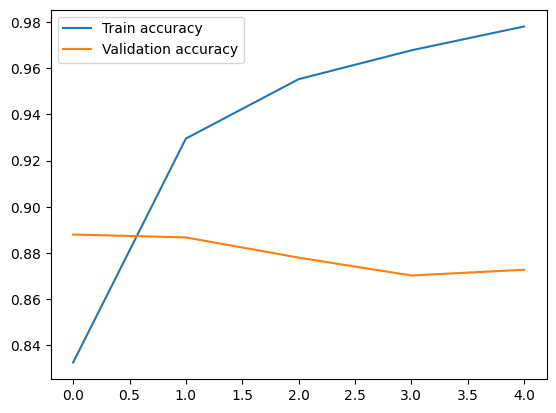

In [17]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

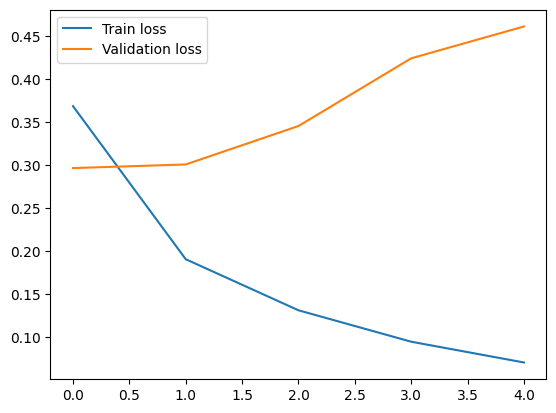

In [18]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

### Model evaluation

In [12]:
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(x_test_seq, max_length)

In [13]:
model = load_model('./sentiment_model.keras')
model.evaluate(x_test_seq, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 68s 212ms/step - accuracy: 0.8934 - loss: 0.2784


[0.2769911587238312, 0.8938999772071838]

In [14]:
predictions = model.predict(x_test_seq, verbose=0)
predictions = np.round(predictions)

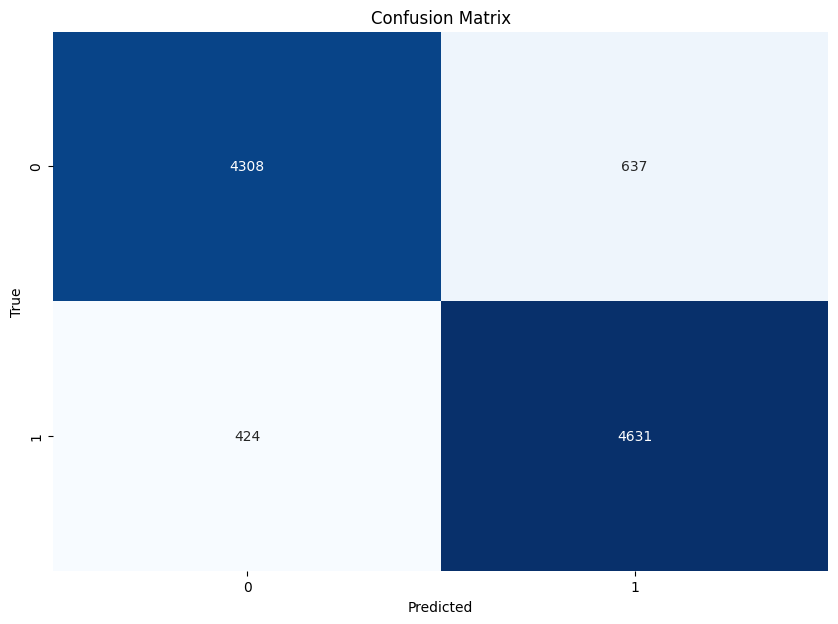

In [15]:
matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')


Accuracy: 0.8939
Recall: 0.9161
F1: 0.8972
